In [1]:
#!fsharp
#r "nuget: Microsoft.ML.ImageAnalytics, 1.5.2"
#r "nuget: Microsoft.ML.Vision, 1.5.2"
#r "nuget: SciSharp.TensorFlow.Redist, 2.3.1"
#r "nuget: SixLabors.ImageSharp, 1.0.2"
#r "nuget: MLOps.NET, 1.3.0"
#r "nuget: MLOps.NET.SQLite, 1.3.0"

Installed package MLOps.NET.SQLite version 1.3.0

Installed package SixLabors.ImageSharp version 1.0.2

Installed package SciSharp.TensorFlow.Redist version 2.3.1

Installed package MLOps.NET version 1.3.0

Installed package Microsoft.ML.Vision version 1.5.2

Installed package Microsoft.ML.ImageAnalytics version 1.5.2

In [1]:
#!fsharp
open System
open System.IO
open Microsoft.ML
open Microsoft.ML.Vision
open Microsoft.ML.Transforms
open Microsoft.ML.Data
open SixLabors.ImageSharp
open SixLabors.ImageSharp.Processing
open Microsoft.DotNet.Interactive.FSharp.FSharpKernelHelpers

In [1]:
#!fsharp
type ImageData =
    { ImagePath: string
      Label: string }

[<CLIMutable>]
type ImageDataAfterPreprocessing =
  { ImagePath: string
    Image: byte[]
    Label: string
    LabelAsKey: UInt32 }

[<CLIMutable>]
type ModelInput =
    { Image: byte[]
      Label: string }

[<CLIMutable>]
type ModelOutput =
    { Image: byte[]
      Label: string
      PredictedLabel: string }

In [1]:
#!fsharp
[<Literal>]
let projectRoot = @"C:\Users\grego\source\repos\IsItKrampus.NET"

let dataDir = Path.Combine(projectRoot, "data")
let prepDir = Path.Combine(dataDir, "prepared")
let workspaceDir = Path.Combine(projectRoot, "workspace")

In [1]:
#!fsharp
// I want to seed my global MLContext
// and my global uniform random generator
// to have at least some reproducibility
let mlContext = MLContext(1)
let rnd = Random(1)

In [1]:
#!fsharp
let loadImagesFromPreparedDir () =
    File.ReadAllLines (Path.Combine(dataDir, "image_prep.csv"))
    |> Array.skip 1
    |> Array.map (fun line ->
        let parts = line.Split(',')
        (parts.[0], parts.[1], bool.Parse parts.[6]))
    |> Array.filter (fun (_, _, isIncluded) -> isIncluded)
    |> Array.map (fun (fileName, label, _) ->
        { ImagePath = fileName
          Label = label })

In [1]:
#!fsharp
let imageData = mlContext.Data.LoadFromEnumerable(loadImagesFromPreparedDir())
let shuffledData = mlContext.Data.ShuffleRows(imageData)

In [1]:
#!fsharp
let preprocessingPipeline =
    EstimatorChain()
        .Append(mlContext.Transforms.Conversion.MapValueToKey(inputColumnName = "Label",
                                                  outputColumnName = "LabelAsKey",
                                                  keyOrdinality = ValueToKeyMappingEstimator.KeyOrdinality.ByValue))
        .Append(mlContext.Transforms
            .LoadRawImageBytes(outputColumnName = "Image",
                               imageFolder = prepDir,
                               inputColumnName = "ImagePath"))

In [1]:
#!fsharp
let preProcessedData =
    preprocessingPipeline.Fit(shuffledData)
        .Transform(shuffledData)

In [1]:
#!fsharp
let trainSplit = mlContext.Data.TrainTestSplit(data = preProcessedData, testFraction = 0.3)
// I need a bigger test fraction because my dataset is relatively small
let validationTestSplit = mlContext.Data.TrainTestSplit(trainSplit.TestSet, testFraction = 0.5)

let trainSet = trainSplit.TrainSet;
let validationSet = validationTestSplit.TrainSet
let testSet = validationTestSplit.TestSet


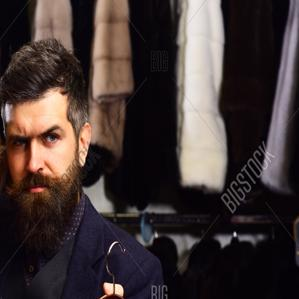

In [1]:
#!fsharp
let preprocessedImagesTrainSet = mlContext.Data.CreateEnumerable<ImageDataAfterPreprocessing>(trainSet, reuseRowObject = false)

preprocessedImagesTrainSet
|> Seq.head
|> fun img -> Convert.ToBase64String img.Image
|> ((sprintf "<img src=\"data:image/png;base64,%s\"></img>") >> DisplayFunctions.HTML)


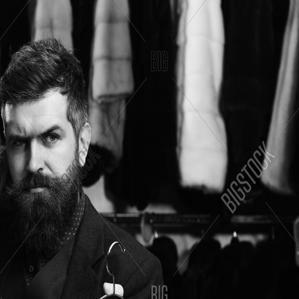

In [1]:
#!fsharp
let imgBytes =
    preprocessedImagesTrainSet
    |> Seq.head
    |> fun img -> img.Image

let turnRight (imgBytes: byte[]) =
    use img = Image.Load(imgBytes)

    let newImage = img.Clone(fun img -> img.Rotate(90f) |> ignore)

    use ms = new MemoryStream()
    newImage.SaveAsJpeg(ms)

    ms.ToArray()

let turnLeft (imgBytes: byte[]) =
    use img = Image.Load(imgBytes)

    let newImage = img.Clone(fun img -> img.Rotate(-90f) |> ignore)

    use ms = new MemoryStream()
    newImage.SaveAsJpeg(ms)

    ms.ToArray()

let flipHorizontally (imgBytes: byte[]) =
    use img = Image.Load(imgBytes)

    let newImage = img.Clone(fun img -> img.RotateFlip(RotateMode.None, FlipMode.Horizontal) |> ignore)

    use ms = new MemoryStream()
    newImage.SaveAsJpeg(ms)

    ms.ToArray()

let grayScale (imgBytes: byte[]) =
    use img = Image.Load(imgBytes)

    let newImage = img.Clone(fun img -> img.Grayscale() |> ignore)

    use ms = new MemoryStream()
    newImage.SaveAsJpeg(ms)

    ms.ToArray()


grayScale imgBytes
|> fun img -> Convert.ToBase64String img
|> ((sprintf "<img src=\"data:image/png;base64,%s\"></img>") >> DisplayFunctions.HTML)

In [1]:
#!fsharp
let randomlyAugment (augmentationBase: ImageDataAfterPreprocessing seq) (percentage: float) (augmentation: byte[] -> byte[]) =
    let randomIndexesToAugment =
        let n = Seq.length augmentationBase
        Seq.init (int ((float n) * percentage)) (fun _ -> rnd.Next(0, n - 1))

    let pick (idxs: int seq) (s: seq<'a>) =
        let arr = Array.ofSeq s
        seq { for idx in idxs -> arr.[idx] }

    let augmentedImages =
        augmentationBase
        |> pick randomIndexesToAugment
        |> Seq.map (fun img -> { img with Image = augmentation img.Image })

    augmentedImages

let augmentedImages =
    [ turnRight; turnLeft; flipHorizontally; grayScale ]
    |> Seq.map (randomlyAugment preprocessedImagesTrainSet 0.1)
    |> Seq.concat

// hacky hacky hack because Key Column types in ML.NET are weird
let postAugmentationPipeline =
    mlContext.Transforms.Conversion.MapValueToKey(inputColumnName = "Label",
                                                  outputColumnName = "LabelAsKey",
                                                  // super important to use `keyOrdinality` consistently
                                                  // otherwise you kill your network performance
                                                  keyOrdinality = ValueToKeyMappingEstimator.KeyOrdinality.ByValue)

let augmentedTrain =
    Seq.concat [ preprocessedImagesTrainSet; augmentedImages ]
    |> fun dataset -> mlContext.Data.LoadFromEnumerable(dataset)
    |> fun dv -> mlContext.Data.ShuffleRows(dv)
    |> fun dv -> postAugmentationPipeline.Fit(dv).Transform(dv)

In [1]:
#!fsharp
let bla =
    mlContext.Data.CreateEnumerable<ImageDataAfterPreprocessing>(augmentedTrain, reuseRowObject = false)

ImagePath,Image,Label,LabelAsKey
dc1fc1f7-15c6-4b4a-a315-4c7842081dea.jpg,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 1, 0, 96, 0, 96, 0, 0 ... (20425 more) ]",Other,2



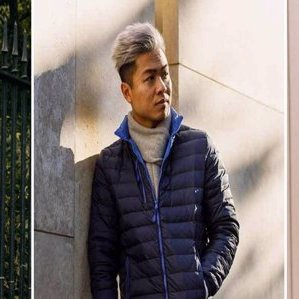

In [1]:
#!fsharp
bla
|> Seq.skip 12
|> Seq.head
|> fun img ->
    display img |> ignore
    Convert.ToBase64String img.Image
|> ((sprintf "<img src=\"data:image/png;base64,%s\"></img>") >> DisplayFunctions.HTML)

In [1]:
#!fsharp
let imageClassifierOptions =
    ImageClassificationTrainer.Options(FeatureColumnName = "Image",
                                       LabelColumnName = "LabelAsKey",
                                       ValidationSet = validationSet,
                                       Arch = ImageClassificationTrainer.Architecture.InceptionV3,
                                       TestOnTrainSet = false,
                                       ReuseTrainSetBottleneckCachedValues = false,
                                       ReuseValidationSetBottleneckCachedValues = false,
                                       Epoch = 400,
                                       MetricsCallback = (fun metrics -> display $"%A{metrics}" |> ignore),
                                       WorkspacePath = workspaceDir)

In [1]:
#!fsharp
let trainingPipeline =
    EstimatorChain()
        .Append(mlContext.MulticlassClassification.Trainers.ImageClassification(imageClassifierOptions))
        .Append(mlContext.Transforms.Conversion.MapKeyToValue("PredictedLabel", "PredictedLabel"))

In [1]:
#!fsharp
let trainedModel = trainingPipeline.Fit augmentedTrain

Saver not created because there are no variables in the graph to restore


Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   1

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   2

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   3

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   4

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   5

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   6

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   7

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   8

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   9

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  10

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  11

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  12

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  13

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  14

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  15

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  16

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  17

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  18

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  19

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  20

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  21

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  22

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  23

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  24

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  25

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  26

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  27

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  28

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  29

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  30

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  31

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  32

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  33

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  34

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  35

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  36

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  37

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  38

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  39

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  40

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  41

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  42

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  43

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  44

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  45

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  46

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  47

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  48

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  49

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  50

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  51

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  52

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  53

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  54

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  55

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  56

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  57

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  58

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  59

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  60

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  61

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  62

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  63

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  64

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  65

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  66

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  67

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  68

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  69

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  70

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  71

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  72

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  73

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  74

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  75

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  76

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  77

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  78

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  79

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  80

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  81

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  82

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  83

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  84

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  85

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  86

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  87

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  88

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  89

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  90

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  91

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   1

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   2

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   3

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   4

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   5

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   6

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   7

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   8

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   9

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  10

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  11

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  12

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  13

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  14

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  15

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  16

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  17

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  18

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  19

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  20

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  21

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  22

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  23

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  24

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  25

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  26

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  27

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  28

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  29

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  30

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  31

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  32

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  33

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  34

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  35

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  36

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  37

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  38

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  39

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  40

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  41

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  42

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  43

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  44

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  45

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  46

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  47

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  48

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  49

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  50

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  51

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  52

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  53

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  54

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  55

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  56

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  57

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  58

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  59

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  60

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  61

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  62

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  63

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  64

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  65

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  66

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  67

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  68

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  69

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  70

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  71

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  72

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  73

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  74

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  75

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  76

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  77

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  78

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  79

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  80

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  81

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  82

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  83

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  84

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  85

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  86

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  87

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  88

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  89

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  90

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  91

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  92

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  93

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  94

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  95

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  96

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  97

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  98

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  99

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 100

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 101

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 102

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 103

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 104

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 105

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 106

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 107

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 108

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 109

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 110

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 111

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 112

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 113

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 114

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 115

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 116

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 117

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 118

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 119

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 120

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 121

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 122

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 123

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 124

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 125

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 126

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 127

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 128

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 129

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 130

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 131

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 132

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 133

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 134

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 135

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 136

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 137

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 138

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 139

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 140

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 141

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 142

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 143

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 144

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 145

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 146

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 147

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 148

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 149

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 150

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 151

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 152

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 153

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 154

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 155

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 156

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 157

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 158

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 159

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 160

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 161

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 162

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 163

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 164

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 165

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 166

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 167

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 168

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 169

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 170

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 171

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 172

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 173

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 174

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 175

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 176

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 177

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 178

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 179

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 180

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 181

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 182

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 183

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 184

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 185

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 186

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 187

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 188

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 189

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 190

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 191

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 192

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 193

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 194

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 195

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 196

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 197

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 198

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 199

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 200

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 201

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 202

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 203

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 204

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 205

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 206

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 207

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 208

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 209

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 210

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 211

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 212

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 213

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 214

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 215

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 216

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 217

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 218

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 219

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 220

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 221

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 222

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 223

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 224

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 225

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 226

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 227

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 228

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 229

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 230

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 231

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 232

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 233

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 234

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 235

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 236

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 237

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 238

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 239

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 240

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 241

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 242

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 243

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 244

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 245

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 246

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 247

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 248

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 249

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 250

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 251

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 252

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 253

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 254

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 255

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 256

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 257

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 258

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 259

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 260

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 261

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 262

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 263

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 264

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 265

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 266

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 267

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 268

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 269

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 270

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 271

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 272

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 273

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 274

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 275

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 276

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 277

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 278

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 279

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 280

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 281

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 282

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 283

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 284

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 285

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 286

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 287

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 288

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 289

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 290

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 291

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 292

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 293

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 294

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 295

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 296

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 297

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 298

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 299

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 300

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 301

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 302

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 303

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 304

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 305

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 306

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 307

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 308

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 309

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 310

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 311

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 312

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 313

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 314

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 315

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 316

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 317

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 318

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 319

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 320

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 321

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 322

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 323

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 324

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 325

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 326

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 327

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 328

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 329

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 330

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 331

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 332

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 333

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 334

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 335

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 336

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 337

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 338

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 339

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 340

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 341

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 342

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 343

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 344

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 345

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 346

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 347

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 348

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 349

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 350

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 351

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 352

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 353

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 354

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 355

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 356

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 357

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 358

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 359

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 360

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 361

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 362

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 363

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 364

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 365

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 366

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 367

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 368

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 369

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 370

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 371

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 372

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 373

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 374

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 375

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 376

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 377

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 378

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 379

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 380

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 381

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 382

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 383

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 384

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 385

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 386

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 387

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 388

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 389

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 390

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 391

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 392

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 393

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 394

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 395

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 396

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 397

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 398

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 399

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 400

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 401

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 402

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 403

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 404

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 405

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 406

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 407

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 408

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 409

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 410

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 411

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 412

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 413

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 414

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 415

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 416

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 417

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 418

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 419

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 420

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 421

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 422

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 423

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 424

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 425

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 426

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 427

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 428

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 429

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 430

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 431

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 432

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 433

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 434

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 435

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 436

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 437

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 438

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 439

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 440

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 441

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 442

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 443

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 444

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 445

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 446

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 447

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 448

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 449

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 450

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 451

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 452

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 453

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 454

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 455

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 456

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 457

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 458

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 459

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 460

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 461

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 462

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 463

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 464

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 465

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 466

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 467

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 468

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 469

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 470

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 471

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 472

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 473

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 474

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 475

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 476

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 477

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 478

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 479

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 480

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 481

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 482

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 483

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 484

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 485

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 486

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 487

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 488

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 489

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 490

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 491

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 492

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 493

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 494

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 495

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 496

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 497

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 498

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 499

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 500

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 501

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 502

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 503

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 504

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 505

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 506

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 507

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 508

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 509

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 510

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 511

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 512

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 513

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 514

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 515

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 516

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 517

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 518

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 519

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 520

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 521

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 522

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 523

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 524

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 525

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 526

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 527

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 528

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 529

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 530

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 531

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 532

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 533

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 534

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 535

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 536

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 537

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 538

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 539

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 540

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 541

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 542

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 543

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 544

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 545

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 546

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 547

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 548

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 549

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 550

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 551

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 552

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 553

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 554

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 555

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 556

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 557

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 558

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 559

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 560

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 561

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 562

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 563

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 564

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 565

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 566

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 567

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 568

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 569

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 570

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 571

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 572

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 573

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 574

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 575

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 576

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 577

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 578

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 579

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 580

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 581

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 582

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 583

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 584

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 585

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 586

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 587

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 588

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 589

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 590

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 591

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 592

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 593

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 594

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 595

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 596

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 597

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 598

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 599

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 600

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 601

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 602

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 603

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 604

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:   0, Accuracy:       0,98, Cross-Entropy: 0,08957331

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:   1, Accuracy: 0,98999995, Cross-Entropy: 0,068147734

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:   2, Accuracy: 0,98999995, Cross-Entropy: 0,058538467

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:   3, Accuracy: 0,98999995, Cross-Entropy: 0,052599818

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:   4, Accuracy: 0,98999995, Cross-Entropy: 0,048582446

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:   5, Accuracy: 0,98999995, Cross-Entropy: 0,04592009

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:   6, Accuracy: 0,98999995, Cross-Entropy: 0,04412596

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:   7, Accuracy: 0,98999995, Cross-Entropy: 0,042835794

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:   8, Accuracy: 0,98999995, Cross-Entropy: 0,04195297

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:   9, Accuracy: 0,98999995, Cross-Entropy: 0,04124478

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:  10, Accuracy: 0,98999995, Cross-Entropy: 0,040759552

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:  11, Accuracy: 0,98999995, Cross-Entropy: 0,04033129

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:  12, Accuracy: 0,98999995, Cross-Entropy: 0,040041648

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:  13, Accuracy: 0,98999995, Cross-Entropy: 0,039764993

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:  14, Accuracy: 0,98999995, Cross-Entropy: 0,039581873

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:  15, Accuracy: 0,98999995, Cross-Entropy: 0,03939499

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:  16, Accuracy: 0,98999995, Cross-Entropy: 0,039274693

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:  17, Accuracy: 0,98999995, Cross-Entropy:  0,0391445

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:  18, Accuracy: 0,98999995, Cross-Entropy: 0,03906349

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:  19, Accuracy: 0,98999995, Cross-Entropy: 0,038970903

Phase: Training, Dataset used: Validation, Batch Processed Count:  10, Epoch:  20, Accuracy: 0,98999995, Cross-Entropy:  0,0389156

Saver not created because there are no variables in the graph to restore


Restoring parameters from C:\Users\grego\source\repos\IsItKrampus.NET\workspace\custom_retrained_model_based_on_inception_v3.meta


Froze 2 variables.


Converted 2 variables to const ops.


In [1]:
#!fsharp
let predictions = trainedModel.Transform testSet

In [1]:
#!fsharp
let metrics = mlContext.MulticlassClassification.Evaluate(predictions, labelColumnName = "LabelAsKey")

In [1]:
#!fsharp
display $"Micro Accuracy: %f{metrics.MicroAccuracy} Macro Accuracy: %f{metrics.MacroAccuracy} Log Loss: %f{metrics.LogLoss}"

Micro Accuracy: 0.978261 Macro Accuracy: 0.978836 Log Loss: 0.067393

In [1]:
#!fsharp
metrics

LogLoss,LogLossReduction,MacroAccuracy,MicroAccuracy,TopKAccuracy,TopKPredictionCount,PerClassLogLoss,ConfusionMatrix
0.06739343047686716,0.9382416280797873,0.978835978835979,0.9782608695652174,0,0,"[ 0.1278741993931759, 0.05377732730981245, 0.003248545037239239 ]",Microsoft.ML.Data.ConfusionMatrix


In [1]:
#!fsharp
let wronglyPredictedOutputs =
    mlContext.Data.CreateEnumerable<ModelOutput>(predictions, reuseRowObject = false)
    |> Seq.filter (fun output -> output.Label <> output.PredictedLabel)
    |> Seq.toList

index,Image,Label,PredictedLabel
0,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0 ... (15290 more) ]",Other,Krampus
1,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 1, 1, 44, 1, 44, 0, 0 ... (31489 more) ]",Krampus,Other



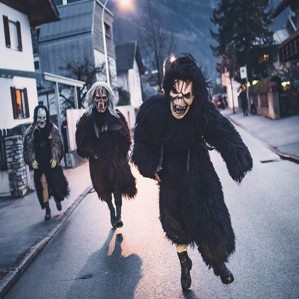

In [1]:
#!fsharp
display wronglyPredictedOutputs

let wronglyPredictedBase64 = Convert.ToBase64String wronglyPredictedOutputs.[1].Image
DisplayFunctions.HTML$"<img src=\"data:image/png;base64,{wronglyPredictedBase64}\"></img>"

In [1]:
#!fsharp
open MLOps.NET
open MLOps.NET.SQLite
open MLOps.NET.Storage
open MLOps.NET.Extensions

let dbFolder = Path.Combine(projectRoot, "data", "mlops-data")
let modelRepo = Path.Combine(dbFolder, "model-repo")
let dbFile = Path.Combine(dbFolder, "localmlops.db")

[<Literal>]
let experimentName = "IsItKrampus.NET"

let mlOps =
    MLOpsBuilder()
        .UseSQLite(dbFile)
        .UseLocalFileModelRepository(modelRepo)
        .Build()

In [1]:
#!fsharp
open System.Threading.Tasks

let doSync (task: Task<'a>) =
    task
    |> Async.AwaitTask
    |> Async.RunSynchronously

let doSyncUnit (task: Task) =
    task
    |> Async.AwaitTask
    |> Async.RunSynchronously

In [1]:
#!fsharp
let run =
    mlOps.LifeCycle.CreateRunAsync(experimentName)
    |> doSync

In [1]:
#!fsharp
let modelDir = Path.Combine(projectRoot, "models")
let modelPath = Path.Combine(modelDir, "model.zip")
mlContext.Model.Save(trainedModel, preProcessedData.Schema, modelPath)

In [1]:
#!fsharp
mlOps.Data.LogDataAsync(run.RunId, imageData)
|> doSyncUnit

mlOps.Training.LogHyperParametersAsync(run.RunId, trainedModel)
|> doSyncUnit

mlOps.Evaluation.LogConfusionMatrixAsync(run.RunId, metrics.ConfusionMatrix)
|> doSyncUnit

mlOps.Evaluation.LogMetricsAsync(run.RunId, metrics)
|> doSyncUnit

In [1]:
#!fsharp
let runArtifact =
    mlOps.Model.UploadAsync(run.RunId, Path.Combine(modelPath))
    |> doSync

let registeredModel =
    mlOps.Model.RegisterModel(run.ExperimentId, runArtifact.RunArtifactId, "@GBeyerle")
    |> doSync

In [1]:
#!fsharp
let mutable predictionPipelineSchema : DataViewSchema = null
let loadedModel = mlContext.Model.Load(modelPath, &predictionPipelineSchema)

In [1]:
#!fsharp
let predictionEngine = mlContext.Model.CreatePredictionEngine<ModelInput, ModelOutput>(loadedModel)


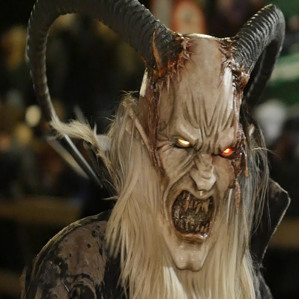

In [1]:
#!fsharp
let getRandom (a: 'a array) =
    let rnd = System.Random()
    let idx = rnd.Next(0, Array.length a - 1)
    a.[idx]

let image =
    loadImagesFromPreparedDir()
    |> getRandom
    |> fun i -> Path.Combine(prepDir, i.ImagePath)
    |> File.ReadAllBytes

let base64 = Convert.ToBase64String image

DisplayFunctions.HTML $"<img src=\"data:image/png;base64,{base64}\"></img>"

In [1]:
#!fsharp
let input : ModelInput =
    { Image = image
      Label = null }

let output = predictionEngine.Predict input

output

Image,Label,PredictedLabel
"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0 ... (31871 more) ]",,Krampus
